/home/laytc/.conda/envs/pymain/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading data...
Preprocessing...
Starting Training...


Training:  25%|██▌       | 5/20 [00:22<01:07,  4.48s/it, Loss=0.0294, Val AUC=0.8404]

  [Scheduler] Epoch 5: LR reduced from 0.001 to 0.0005


Training:  45%|████▌     | 9/20 [00:40<00:48,  4.44s/it, Loss=0.0288, Val AUC=0.8407]

  [Scheduler] Epoch 9: LR reduced from 0.0005 to 0.00025


Training:  60%|██████    | 12/20 [00:53<00:35,  4.44s/it, Loss=0.0286, Val AUC=0.8400]

  [Scheduler] Epoch 12: LR reduced from 0.00025 to 0.000125


Training:  75%|███████▌  | 15/20 [01:07<00:22,  4.48s/it, Loss=0.0285, Val AUC=0.8395]

  [Scheduler] Epoch 15: LR reduced from 0.000125 to 6.25e-05


Training:  90%|█████████ | 18/20 [01:20<00:08,  4.49s/it, Loss=0.0284, Val AUC=0.8403]

  [Scheduler] Epoch 18: LR reduced from 6.25e-05 to 3.125e-05


Training: 100%|██████████| 20/20 [01:29<00:00,  4.49s/it, Loss=0.0284, Val AUC=0.8403]


Training Complete. Best Val AUC: 0.8420

--- Best F1 Optimization ---
Optimal Threshold: 0.4722
Resulting Recall:  0.6507
Resulting Precision: 0.6173
Max F1 Score:      0.6335

--- Final Test Report ---
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82     89173
         1.0       0.62      0.65      0.63     42676

    accuracy                           0.76    131849
   macro avg       0.72      0.73      0.73    131849
weighted avg       0.76      0.76      0.76    131849



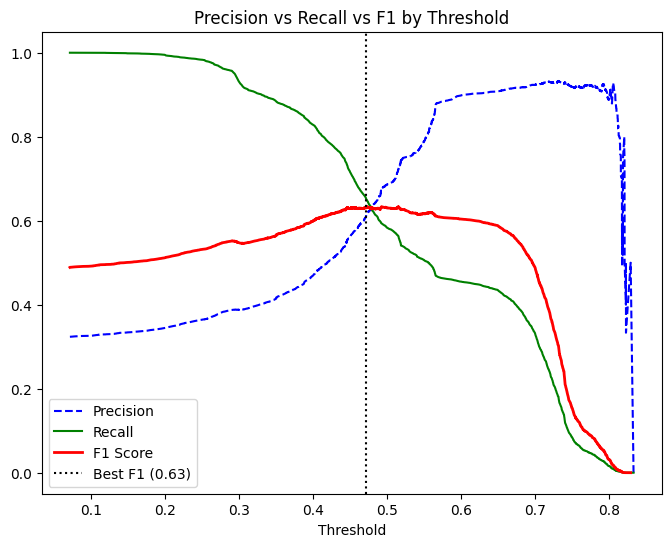

[Test (tuned)]
              precision    recall  f1-score   support

         0.0      0.828     0.807     0.818     89173
         1.0      0.617     0.651     0.634     42676

    accuracy                          0.756    131849
   macro avg      0.723     0.729     0.726    131849
weighted avg      0.760     0.756     0.758    131849

AUC-PR: 0.7279 | AUC-ROC: 0.8077


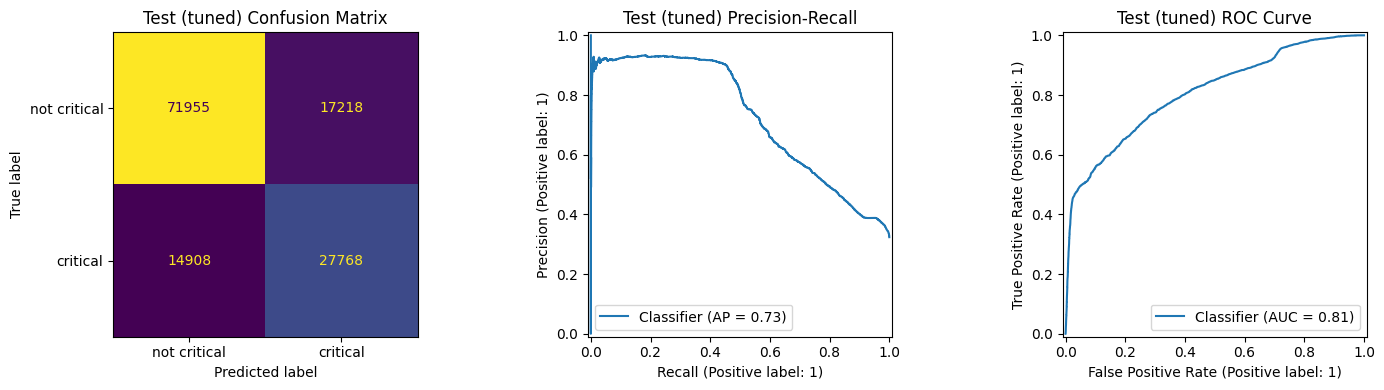

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm  # <--- Added for progress tracking

# --- Configuration ---
DATA_DIR = Path("../data_final")
TRAIN_PATH = DATA_DIR / "vm_train.parquet"
VAL_PATH   = DATA_DIR / "vm_val.parquet"
TEST_PATH  = DATA_DIR / "vm_test.parquet"

TARGET_COL = "critical"
BATCH_SIZE = 2048
EPOCHS = 20
LEARNING_RATE = 0.001
EMBEDDING_DIM = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load Data
# ------------------------------------------------------------------------------
print("Loading data...")
df_train = pl.read_parquet(TRAIN_PATH)
df_val   = pl.read_parquet(VAL_PATH)
df_test  = pl.read_parquet(TEST_PATH)

# 2. Strict Safe Features
# ------------------------------------------------------------------------------
feat_timing = ["day_idx", "hour_of_day", "ts_vm_created", "ts_first_vm_created"]
feat_static = [
    "vm_virtual_core_count", "vm_memory_gb", "vm_mem_per_core", 
    "deployment_size", "log_deployment_size", "count_vms_created", 
    "sub_first_day", "sub_first_hour"
]
feat_history = [c for c in df_train.columns if c.startswith("hist_")]

NUMERIC_COLS = feat_timing + feat_static + feat_history
CAT_COLS = ["vm_category", "subscription_id"]

# 3. Preprocessing
# ------------------------------------------------------------------------------
print("Preprocessing...")

def prepare_pandas(df_polars):
    return df_polars.select(NUMERIC_COLS + CAT_COLS + [TARGET_COL]).to_pandas()

X_train = prepare_pandas(df_train)
X_val   = prepare_pandas(df_val)
X_test  = prepare_pandas(df_test)

# Scale Numerics
scaler = StandardScaler()
X_train[NUMERIC_COLS] = scaler.fit_transform(X_train[NUMERIC_COLS].fillna(0))
X_val[NUMERIC_COLS]   = scaler.transform(X_val[NUMERIC_COLS].fillna(0))
X_test[NUMERIC_COLS]  = scaler.transform(X_test[NUMERIC_COLS].fillna(0))

# Encode Categoricals
cat_dims = {}
for col in CAT_COLS:
    le = LabelEncoder()
    vals = X_train[col].astype(str).unique()
    le.fit(np.append(vals, "<UNK>"))
    
    def safe_transform(series):
        series = series.astype(str)
        mask = series.isin(le.classes_)
        series[~mask] = "<UNK>"
        return le.transform(series)
    
    X_train[col] = safe_transform(X_train[col])
    X_val[col]   = safe_transform(X_val[col])
    X_test[col]  = safe_transform(X_test[col])
    cat_dims[col] = len(le.classes_)

# 4. Dataset & Model
# ------------------------------------------------------------------------------
class VMDataset(Dataset):
    def __init__(self, df, num_cols, cat_cols):
        self.num = torch.tensor(df[num_cols].values, dtype=torch.float32)
        self.cat = torch.tensor(df[cat_cols].values, dtype=torch.long)
        self.y   = torch.tensor(df[TARGET_COL].values, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.num[i], self.cat[i], self.y[i]

train_loader = DataLoader(VMDataset(X_train, NUMERIC_COLS, CAT_COLS), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(VMDataset(X_val, NUMERIC_COLS, CAT_COLS), batch_size=BATCH_SIZE)
test_loader  = DataLoader(VMDataset(X_test, NUMERIC_COLS, CAT_COLS), batch_size=BATCH_SIZE)

class Net(nn.Module):
    def __init__(self, num_dim, cat_dims):
        super().__init__()
        self.emb_cat = nn.Embedding(cat_dims['vm_category'], 4)
        self.emb_sub = nn.Embedding(cat_dims['subscription_id'], EMBEDDING_DIM)
        
        in_dim = num_dim + 4 + EMBEDDING_DIM
        
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128),    nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64),     nn.BatchNorm1d(64),  nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
        
    def forward(self, x_num, x_cat):
        e1 = self.emb_cat(x_cat[:,0])
        e2 = self.emb_sub(x_cat[:,1])
        x = torch.cat([x_num, e1, e2], dim=1)
        return self.mlp(x)

model = Net(len(NUMERIC_COLS), cat_dims).to(device)

# 5. Training with TQDM & Fixed Scheduler
# ------------------------------------------------------------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        bce = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        return (self.alpha * (1-pt)**self.gamma * bce).mean()

criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# FIX: Remove 'verbose=True'
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

print("Starting Training...")
best_val_auc = 0

# TQDM Progress Bar for Epochs
pbar = tqdm(range(EPOCHS), desc="Training")

for epoch in pbar:
    model.train()
    total_loss = 0
    
    # Optional: Inner loop progress bar for batches if epochs are very long
    # for xn, xc, y in tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}"):
    for xn, xc, y in train_loader:
        xn, xc, y = xn.to(device), xc.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xn, xc), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    
    # Validation
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xn, xc, y in val_loader:
            xn, xc, y = xn.to(device), xc.to(device), y.to(device)
            preds.extend(torch.sigmoid(model(xn, xc)).cpu().numpy())
            targets.extend(y.cpu().numpy())
            
    val_auc = roc_auc_score(targets, preds)
    
    # Step scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_auc)
    new_lr = optimizer.param_groups[0]['lr']
    
    if new_lr < old_lr:
        print(f"  [Scheduler] Epoch {epoch+1}: LR reduced from {old_lr} to {new_lr}")
    
    # Update Progress Bar
    pbar.set_postfix({"Loss": f"{avg_loss:.4f}", "Val AUC": f"{val_auc:.4f}"})
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model.pth")

print(f"Training Complete. Best Val AUC: {best_val_auc:.4f}")

# 6. Final Evaluation (Maximize F1)
# ------------------------------------------------------------------------------
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_preds, test_targets = [], []
with torch.no_grad():
    for xn, xc, y in test_loader:
        xn, xc, y = xn.to(device), xc.to(device), y.to(device)
        test_preds.extend(torch.sigmoid(model(xn, xc)).cpu().numpy())
        test_targets.extend(y.cpu().numpy())

test_preds = np.array(test_preds).ravel()
test_targets = np.array(test_targets).ravel()

# Optimization
precisions, recalls, thresholds = precision_recall_curve(test_targets, test_preds)
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.nanargmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n--- Best F1 Optimization ---")
print(f"Optimal Threshold: {best_thresh:.4f}")
print(f"Resulting Recall:  {recalls[best_idx]:.4f}")
print(f"Resulting Precision: {precisions[best_idx]:.4f}")
print(f"Max F1 Score:      {best_f1:.4f}")

# Final Report
final_classes = (test_preds >= best_thresh).astype(int)
print("\n--- Final Test Report ---")
print(classification_report(test_targets, final_classes))

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "r-", linewidth=2, label="F1 Score")
plt.axvline(best_thresh, color='black', linestyle=':', label=f"Best F1 ({best_f1:.2f})")
plt.legend()
plt.title("Precision vs Recall vs F1 by Threshold")
plt.xlabel("Threshold")
plt.show()
# Standardized evaluation (report + curves + confusion matrix)
def evaluate_split(y_true, scores, preds, split_name: str):
    pr_auc = average_precision_score(y_true, scores)
    roc_auc = roc_auc_score(y_true, scores)

    print(f"[{split_name}]")
    print(classification_report(y_true, preds, digits=3, zero_division=0))
    print(f"AUC-PR: {pr_auc:.4f} | AUC-ROC: {roc_auc:.4f}")

    cm = confusion_matrix(y_true, preds)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ConfusionMatrixDisplay(cm, display_labels=["not critical", "critical"]).plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f"{split_name} Confusion Matrix")
    PrecisionRecallDisplay.from_predictions(y_true, scores, ax=axes[1])
    axes[1].set_title(f"{split_name} Precision-Recall")
    RocCurveDisplay.from_predictions(y_true, scores, ax=axes[2])
    axes[2].set_title(f"{split_name} ROC Curve")
    plt.tight_layout()
    plt.show()

# Evaluate final test split with tuned threshold
evaluate_split(test_targets, test_preds, final_classes, "Test (tuned)")
